In [1]:
# a script to run the spike interface on Diao's data with visualisation


#import the necessary packages
from pathlib import Path
import platform
import os
import shutil
import argparse
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface.sorters
import spikeinterface.full as si
import  scipy.signal
import spikeinterface.extractors as se
import spikeinterface.comparison
import spikeinterface.exporters
import spikeinterface.curation
import spikeinterface.widgets 
import docker


In [10]:
#grab recordings from the server to local machine (Beast)
base_folder = '/mnt/rds01/ibn-vision/DATA/SUBJECTS/'
mouse = 'M23038'
date = '20230817'
# get all the recordings on that day
ephys_folder = base_folder + mouse + '/ephys/' + date +'/'
# same if loading from server
dst_folder = ephys_folder[:-1]
print(dst_folder)



/mnt/rds01/ibn-vision/DATA/SUBJECTS/M23038/ephys/20230817


In [11]:
stream_names, stream_ids = si.get_neo_streams('spikeglx',dst_folder)
print(stream_names)
print(stream_ids)

['imec0.ap', 'imec1.ap', 'imec0.lf', 'imec1.lf']
['imec0.ap', 'imec1.ap', 'imec0.lf', 'imec1.lf']


In [12]:
#load first probe from beast folder - MEC probe for Diao
probe0_raw = si.read_spikeglx(dst_folder,stream_name=stream_names[0])
print(probe0_raw)
#Load second probe - V1 probe
probe1_raw = si.read_spikeglx(dst_folder,stream_name = stream_names[1])
print(probe1_raw)

#plot channel maps of the probes
#fig, ax =plt.subplots(figsize=(15, 10))
#si.plot_probe_map(probe0_raw,ax=ax,with_channels_ids=True)
#ax.set_ylim(-100,100)

SpikeGLXRecordingExtractor: 384 channels - 30.0kHz - 4 segments - 163,220,917 samples 
                            5,440.70s (1.51 hours) - int16 dtype - 116.74 GiB
Segments:
Samples:   127,940,244 | 4,387,152 | 18,366,648 | 12,526,873
Durations: 4,264.67s (1.18 hours) | 146.24s (2.44 minutes) | 612.22s (10.20 minutes) | 417.56s (6.96 minutes)
Memory:    91.51 GiB | 3.14 GiB | 13.14 GiB | 8.96 GiB
SpikeGLXRecordingExtractor: 384 channels - 30.0kHz - 4 segments - 163,222,057 samples 
                            5,440.74s (1.51 hours) - int16 dtype - 116.75 GiB
Segments:
Samples:   127,940,532 | 4,387,440 | 18,366,912 | 12,527,173
Durations: 4,264.68s (1.18 hours) | 146.25s (2.44 minutes) | 612.23s (10.20 minutes) | 417.57s (6.96 minutes)
Memory:    91.51 GiB | 3.14 GiB | 13.14 GiB | 8.96 GiB


In [13]:
#several preprocessing steps and concatenation of the recordings
%timeit
#highpass filter - threhsold at 300Hz
probe0_highpass = si.highpass_filter(probe0_raw,freq_min=300.)
#detect bad channels
bad_channel_ids, channel_labels = si.detect_bad_channels(probe0_highpass)
#remove bad channels if wanted
probe0_remove_channels = probe0_highpass.remove_channels(bad_channel_ids)
print('bad_channel_ids',bad_channel_ids)
#phase shift correction - equivalent to T-SHIFT in catGT
probe0_phase_shift = si.phase_shift(probe0_remove_channels)
probe0_common_reference = si.common_reference(probe0_phase_shift,operator='median',reference='global')
probe0_preprocessed = probe0_common_reference
probe0_cat = si.concatenate_recordings([probe0_preprocessed])
print('probe0_preprocessed',probe0_preprocessed)
print('probe0 concatenated',probe0_cat)

probe1_highpass = si.highpass_filter(probe1_raw,freq_min=300.)
bad_channel_ids, channel_labels = si.detect_bad_channels(probe1_highpass)
probe1_remove_channels = probe1_highpass.remove_channels(bad_channel_ids)
print('bad_channel_ids',bad_channel_ids)
probe1_phase_shift = si.phase_shift(probe1_remove_channels)
probe1_common_reference = si.common_reference(probe1_phase_shift,operator='median',reference='global')
probe1_preprocessed = probe1_common_reference
probe1_cat = si.concatenate_recordings([probe1_preprocessed])
print('probe1_preprocessed',probe0_preprocessed)
print('probe1 concatenated',probe1_cat)

bad_channel_ids ['imec0.ap#AP28' 'imec0.ap#AP191' 'imec0.ap#AP354' 'imec0.ap#AP367'
 'imec0.ap#AP368' 'imec0.ap#AP369' 'imec0.ap#AP370' 'imec0.ap#AP371'
 'imec0.ap#AP372' 'imec0.ap#AP373' 'imec0.ap#AP374' 'imec0.ap#AP375'
 'imec0.ap#AP376' 'imec0.ap#AP377' 'imec0.ap#AP378' 'imec0.ap#AP379'
 'imec0.ap#AP380' 'imec0.ap#AP381' 'imec0.ap#AP382' 'imec0.ap#AP383']
probe0_preprocessed CommonReferenceRecording: 364 channels - 30.0kHz - 4 segments - 163,220,917 samples 
                          5,440.70s (1.51 hours) - int16 dtype - 110.66 GiB
Segments:
Samples:   127,940,244 | 4,387,152 | 18,366,648 | 12,526,873
Durations: 4,264.67s (1.18 hours) | 146.24s (2.44 minutes) | 612.22s (10.20 minutes) | 417.56s (6.96 minutes)
Memory:    86.74 GiB | 2.97 GiB | 12.45 GiB | 8.49 GiB
probe0 concatenated ConcatenateSegmentRecording: 364 channels - 30.0kHz - 1 segments - 163,220,917 samples 
                             5,440.70s (1.51 hours) - int16 dtype - 110.66 GiB
bad_channel_ids ['imec1.ap#AP191' '

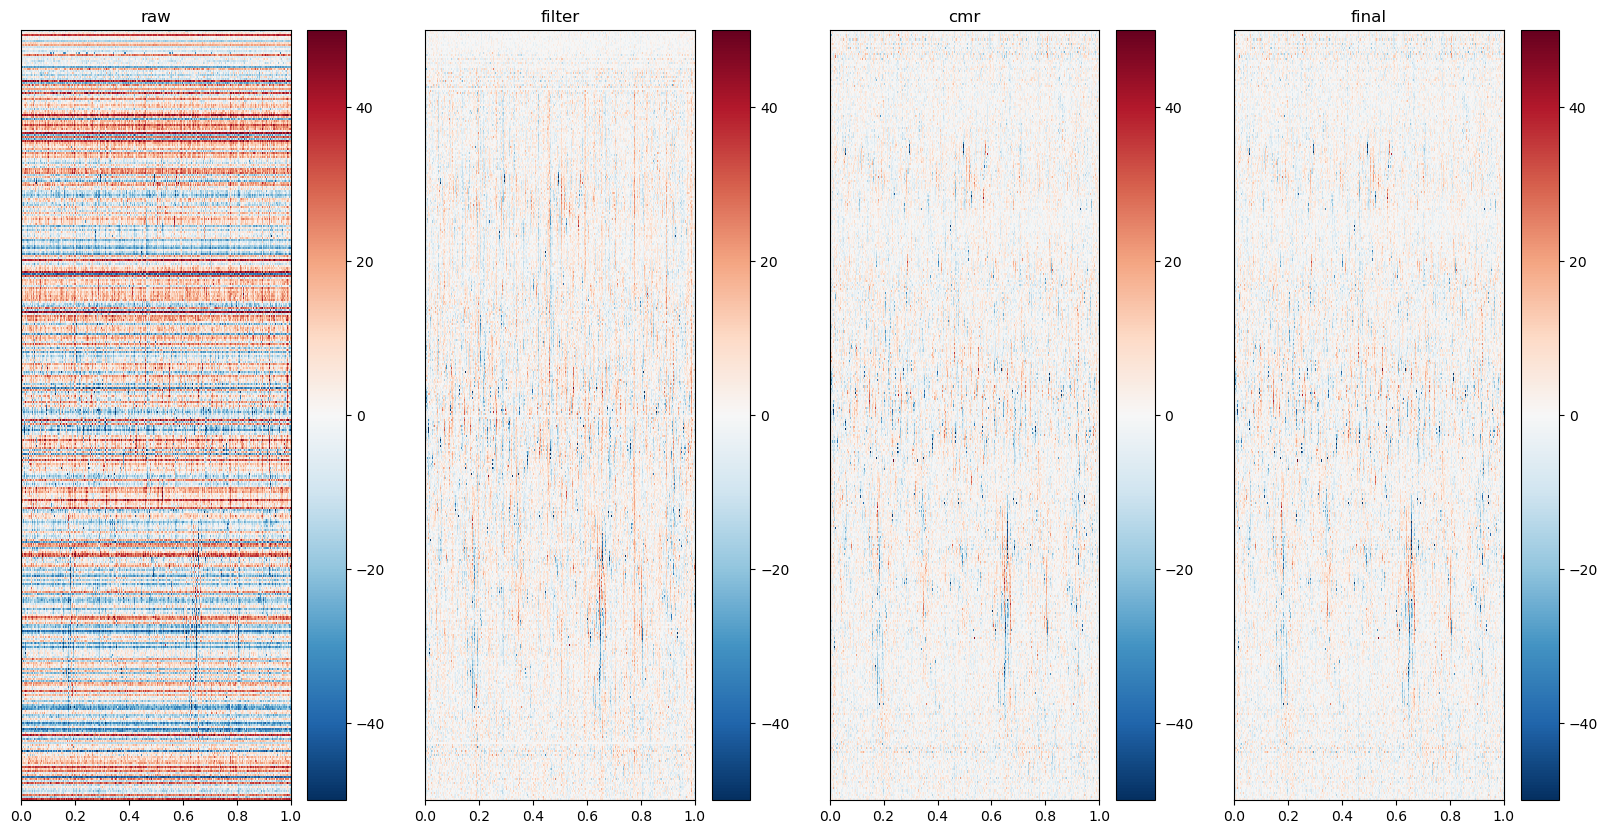

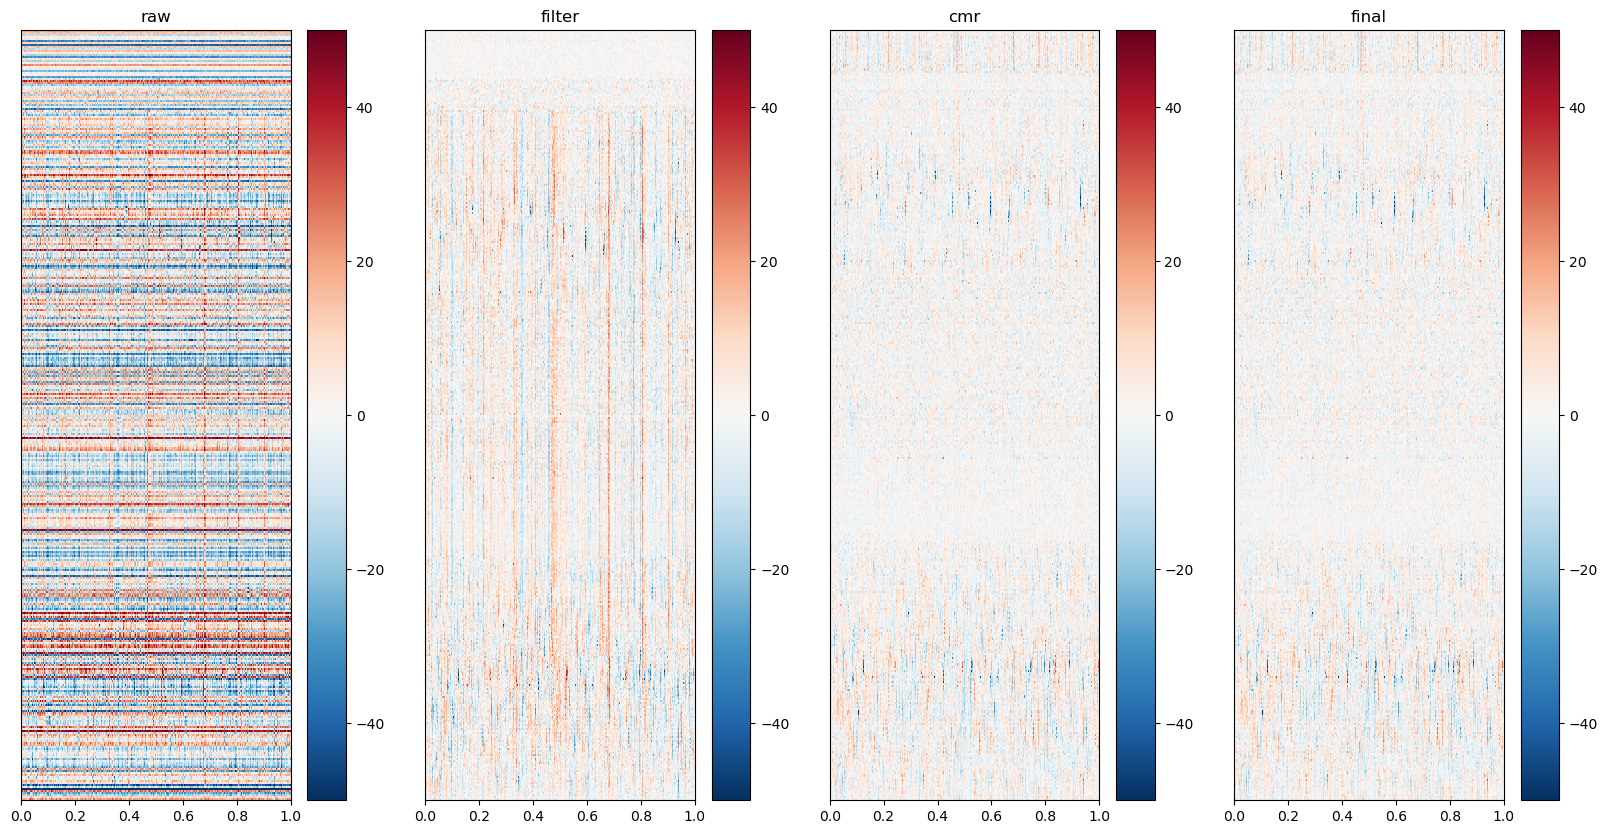

In [14]:
#visualisation of preprocessing steps

#First Probe
fig, axs = plt.subplots(ncols=4, figsize=(20, 10))
#concatenated recordings from each step of preprocessing and compare
si.plot_traces(si.concatenate_recordings([probe0_raw]), backend='matplotlib',  clim=(-50, 50), ax=axs[0])
si.plot_traces(si.concatenate_recordings([probe0_highpass]), backend='matplotlib',  clim=(-50, 50), ax=axs[1])
si.plot_traces(si.concatenate_recordings([probe0_common_reference]), backend='matplotlib',  clim=(-50, 50), ax=axs[2])
si.plot_traces(si.concatenate_recordings([probe0_preprocessed]), backend='matplotlib',  clim=(-50, 50), ax=axs[3])
for i, label in enumerate(('raw','filter', 'cmr', 'final')):
    axs[i].set_title(label)



#Second Probe
fig, axs = plt.subplots(ncols=4, figsize=(20, 10))
#concatenated recordings from each step of preprocessing and compare
si.plot_traces(si.concatenate_recordings([probe1_raw]), backend='matplotlib',  clim=(-50, 50), ax=axs[0])
si.plot_traces(si.concatenate_recordings([probe1_highpass]), backend='matplotlib',  clim=(-50, 50), ax=axs[1])
si.plot_traces(si.concatenate_recordings([probe1_common_reference]), backend='matplotlib',  clim=(-50, 50), ax=axs[2])
si.plot_traces(si.concatenate_recordings([probe1_preprocessed]), backend='matplotlib',  clim=(-50, 50), ax=axs[3])
for i, label in enumerate(('raw','filter', 'cmr', 'final')):
    axs[i].set_title(label)

Text(0.5, 0, 'Second Probe noise  [microV]')

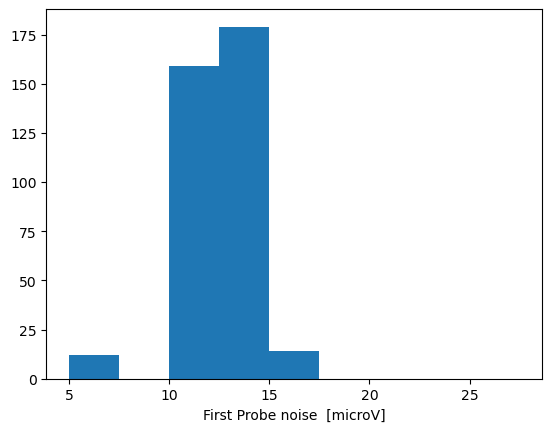

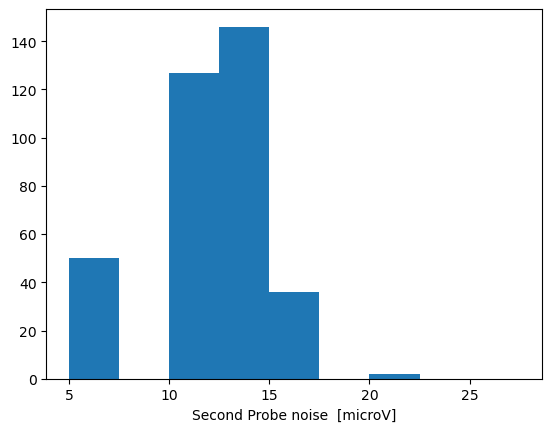

In [15]:
#Check noise level
# we can estimate the noise on the scaled traces (microV) or on the raw one (which is in our case int16).
#First Probe
%timeit
probe0_noise_levels_microV = si.get_noise_levels(probe0_cat, return_scaled=True)
probe0_noise_levels_int16 = si.get_noise_levels(probe0_cat, return_scaled=False)
fig, ax = plt.subplots()
_ = ax.hist(probe0_noise_levels_microV, bins=np.arange(5, 30, 2.5))
ax.set_xlabel('First Probe noise  [microV]')

#Second Probe
probe1_noise_levels_microV = si.get_noise_levels(probe1_cat, return_scaled=True)
probe1_noise_levels_int16 = si.get_noise_levels(probe1_cat, return_scaled=False)
fig, ax = plt.subplots()
_ = ax.hist(probe1_noise_levels_microV, bins=np.arange(5, 30, 2.5))
ax.set_xlabel('Second Probe noise  [microV]')

In [16]:
#Check motion drifts
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

job_kwargs = dict(n_jobs=20, chunk_duration='1s', progress_bar=True)
probe0_peaks = detect_peaks(probe0_cat,  method='locally_exclusive', noise_levels=probe0_noise_levels_int16,
                     detect_threshold=5, radius_um=50., **job_kwargs)
probe0_peaks

from spikeinterface.sortingcomponents.peak_localization import localize_peaks

probe0_peak_locations = localize_peaks(probe0_cat, probe0_peaks, method='center_of_mass', radius_um=50., **job_kwargs)

detect peaks using locally_exclusive:   0%|          | 0/5441 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/5441 [00:00<?, ?it/s]

In [17]:
# check for drifts
probe0_peaks

array([(        9, 185, -40., 0), (       12, 108, -30., 0),
       (       13,  97, -43., 0), ..., (163220912,  64, -24., 0),
       (163220912, 194, -62., 0), (163220914,  87, -30., 0)],
      dtype=[('sample_index', '<i8'), ('channel_index', '<i8'), ('amplitude', '<f8'), ('segment_index', '<i8')])

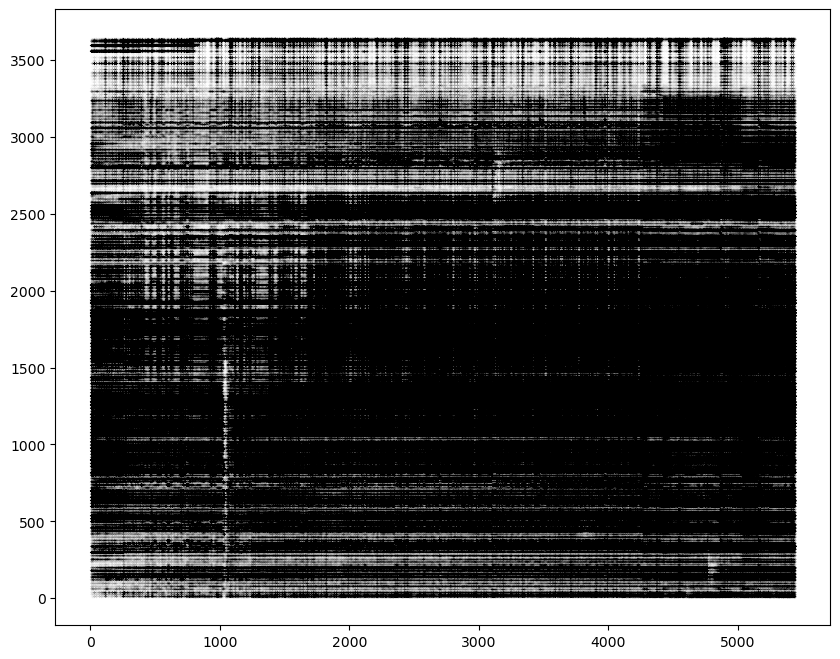

In [18]:

fs = probe0_cat.sampling_frequency
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(probe0_peaks['sample_index'] / fs, probe0_peak_locations['y'], color='k', marker='.',  alpha=0.002,s=1.3)

In [19]:
%timeit
job_kwargs = dict(n_jobs=20, chunk_duration='1s', progress_bar=True)
probe1_peaks = detect_peaks(probe1_cat,  method='locally_exclusive', noise_levels=probe1_noise_levels_int16,
                     detect_threshold=5, radius_um=50., **job_kwargs)
probe1_peaks


probe1_peak_locations = localize_peaks(probe1_cat, probe1_peaks, method='center_of_mass', radius_um=50., **job_kwargs)

detect peaks using locally_exclusive:   0%|          | 0/5441 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/5441 [00:00<?, ?it/s]

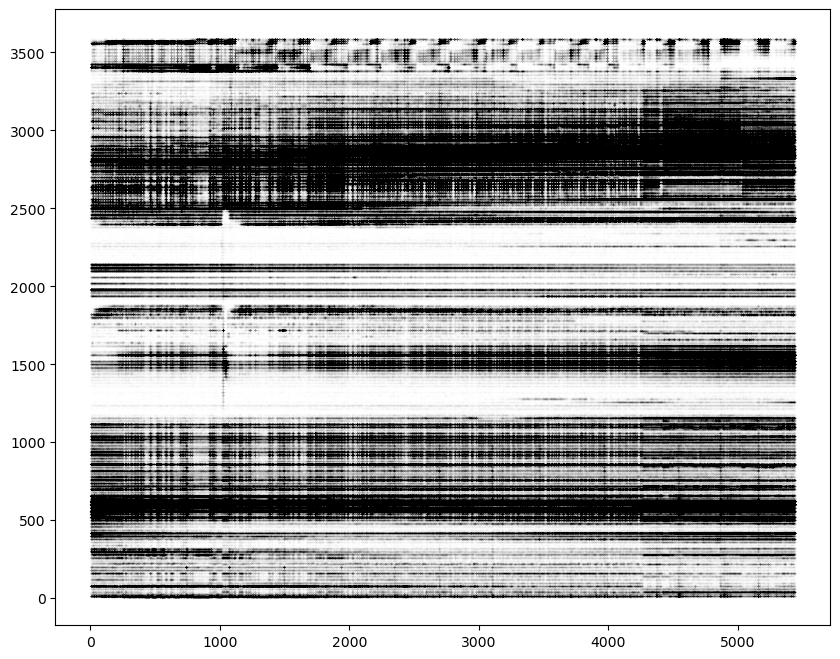

In [20]:
# check for drifts
%timeit

fs = probe1_cat.sampling_frequency
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(probe1_peaks['sample_index']/fs, probe1_peak_locations['y'], color='k', marker='.',  alpha=0.002,s=1.3)

s)

In [21]:
#motion correction if needed
%timeit
#this is nonrigid correction - need to do parallel computing to speed up
job_kwargs = dict(n_jobs=20, chunk_duration='1s', progress_bar=True)
probe0_nonrigid_accurate = si.correct_motion(recording=probe0_cat, preset="nonrigid_accurate",**job_kwargs)
probe1_nonrigid_accurate = si.correct_motion(recording=probe1_cat, preset="nonrigid_accurate",**job_kwargs)

#kilosort like to mimic kilosort - no need if you are just running kilosort
#probe0_kilosort_like = correct_motion(recording=probe0_cat, preset="kilosort_like")
#probe1_kilosort_like = correct_motion(recording=probe1_cat, preset="kilosort_like")

detect and localize:   0%|          | 0/5441 [00:00<?, ?it/s]

detect and localize:   0%|          | 0/5441 [00:00<?, ?it/s]

In [25]:
#save preprocessed bin file before sorting
%timeit
job_kwargs = dict(n_jobs=20, chunk_duration='1s', progress_bar=True)
probe0_preprocessed_corrected = probe0_nonrigid_accurate.save(folder=dst_folder+'/probe0_preprocessed', format='binary',overwrite=True, **job_kwargs)
probe1_preprocessed_corrected = probe1_nonrigid_accurate.save(folder=dst_folder+'/probe1_preprocessed', format='binary', **job_kwargs)

FileNotFoundError: [Errno 2] No such file or directory: 'traces_cached_seg0.raw'

In [ ]:
#start sorting in parallel
#sorter list
%timeit
job_list = [
  {'sorter_name':'kilosort2_5','recording':probe0_preprocessed_corrected,'output_folder':dst_folder+'/probe0/sorters/kilosort2_5/','docker_image':'spikeinterface/kilosort2_5-compiled-base','do_correction':False},
  {'sorter_name':'kilosort3','recording':probe0_preprocessed_corrected,'output_folder':dst_folder+'/probe0/sorters/kilosort3/','docker_image':True,'do_correction':False},
 # {'sorter_name':'mountainsort5','recording':probe0_preprocessed_corrected,'output_folder':dst_folder+'/probe0/sorters/mountainsort5/','docker_image':True},
    {'sorter_name':'kilosort2_5','recording':probe1_preprocessed_corrected,'output_folder':dst_folder+'/probe1/sorters/kilosort2_5/','docker_image':'spikeinterface/kilosort2_5-compiled-base','do_correction':False},
  {'sorter_name':'kilosort3','recording':probe1_preprocessed_corrected,'output_folder':dst_folder+'/probe1/sorters/kilosort3/','docker_image':True,'do_correction':False},
 # {'sorter_name':'mountainsort5','recording':probe1_preprocessed_corrected,'output_folder':dst_folder+'/probe1/sorters/mountainsort5/','docker_image':True},
]
#run sorters in parallel
sortings = si.run_sorter_jobs(job_list = job_list,engine = 'joblib',engine_kwargs = {'n_jobs': 2})
print(sortings)


In [1]:
from spikeinterface.sorters import installed_sorters
installed_sorters()


KeyboardInterrupt



In [ ]:
#extract waveforms from sorted data

probe0_sorting_ks2_5 = spikeinterface.sorters.read_sorter_folder(dst_folder+'/probe0/sorters/kilosort2_5/', register_recording=True, sorting_info=True, raise_error=True)
probe0_we_ks2_5 = si.extract_waveforms(probe0_preprocessed_corrected, probe0_sorting_ks2_5, folder=dst_folder +'/probe0/waveform/kilosort2_5',
                          sparse=True, max_spikes_per_unit=500, ms_before=1.5,ms_after=2.,
                          **job_kwargs)

probe0_sorting_ks3 = spikeinterface.sorters.read_sorter_folder(dst_folder+'/probe0/sorters/kilosort3/', register_recording=True, sorting_info=True, raise_error=True)
probe0_we_ks3 = si.extract_waveforms(probe0_preprocessed_corrected, probe0_sorting_ks3, folder=dst_folder +'/probe0/waveform/kilosort3',
                          sparse=True, max_spikes_per_unit=500, ms_before=1.5,ms_after=2.,
                          **job_kwargs)

probe1_sorting_ks2_5 = spikeinterface.sorters.read_sorter_folder(dst_folder+'/probe1/sorters/kilosort2_5/', register_recording=True, sorting_info=True, raise_error=True)
probe1_we_ks2_5 = si.extract_waveforms(probe1_preprocessed_corrected, probe1_sorting_ks2_5, folder=dst_folder +'/probe1/waveform/kilosort2_5',
                          sparse=True, max_spikes_per_unit=500, ms_before=1.5,ms_after=2.,
                          **job_kwargs)

probe1_sorting_ks3 = spikeinterface.sorters.read_sorter_folder(dst_folder+'/probe1/sorters/kilosort3/', register_recording=True, sorting_info=True, raise_error=True)
probe1_we_ks3 = si.extract_waveforms(probe1_preprocessed_corrected, probe1_sorting_ks3, folder=dst_folder +'/probe1/waveform/kilosort3',
                          sparse=True, max_spikes_per_unit=500, ms_before=1.5,ms_after=2.,
                          **job_kwargs)

In [ ]:
#quality metrics
probe0_ks2_5_metrics = si.compute_quality_metrics(probe0_we_ks2_5, metric_names=['firing_rate', 'presence_ratio', 'snr',
                                                       'isi_violation', 'amplitude_cutoff'])

probe0_ks3_metrics = si.compute_quality_metrics(probe0_we_ks3, metric_names=['firing_rate', 'presence_ratio', 'snr',
                                                       'isi_violation', 'amplitude_cutoff'])
probe1_ks2_5_metrics = si.compute_quality_metrics(probe1_we_ks2_5, metric_names=['firing_rate', 'presence_ratio', 'snr',
                                                       'isi_violation', 'amplitude_cutoff'])
probe1_ks3_metrics = si.compute_quality_metrics(probe1_we_ks3, metric_names=['firing_rate', 'presence_ratio', 'snr',
                                                       'isi_violation', 'amplitude_cutoff'])

In [ ]:
#curation - similiar to allen
amplitude_cutoff_thresh = 0.1
isi_violations_ratio_thresh = 1
presence_ratio_thresh = 0.9

our_query = f"(amplitude_cutoff < {amplitude_cutoff_thresh}) & (isi_violations_ratio < {isi_violations_ratio_thresh}) & (presence_ratio > {presence_ratio_thresh})"
probe0_ks2_5_keep_units = probe0_ks2_5_metrics.query(our_query)
probe0_ks2_5_keep_unit_ids = probe0_ks2_5_keep_units.index.values
probe0_ks2_5_we_clean = probe0_we_ks2_5.select_units(probe0_ks2_5_keep_unit_ids, new_folder=dst_folder +'/probe0/waveform_clean/kilosort2_5')

probe0_ks3_keep_units = probe0_ks3_metrics.query(our_query)
probe0_ks3_keep_unit_ids = probe0_ks3_keep_units.index.values
probe0_ks3_we_clean = probe0_we_ks3.select_units(probe0_ks3_keep_unit_ids, new_folder=dst_folder +'/probe0/waveform_clean/kilosort3')

probe1_ks2_5_keep_units = probe1_ks2_5_metrics.query(our_query)
probe1_ks2_5_keep_unit_ids = probe1_ks2_5_keep_units.index.values
probe1_ks2_5_we_clean = probe1_we_ks2_5.select_units(probe1_ks2_5_keep_unit_ids, new_folder=dst_folder +'/probe1/waveform_clean/kilosort2_5')


probe1_ks3_keep_units = probe1_ks3_metrics.query(our_query)
probe1_ks3_keep_unit_ids = probe1_ks3_keep_units.index.values
probe1_ks3_we_clean = probe1_we_ks3.select_units(probe1_ks3_keep_unit_ids, new_folder=dst_folder +'/probe1/waveform_clean/kilosort3')